# Import necessary packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Loading Data from Google Drive
Images in the original dataset have been converted into 256*256 .png format

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive"

'Colab Notebooks'			      test.csv
 DMML2_CA_Breast_Cancer_Detection_CNN.ipynb   testing_images
 RSNA_256				      testing_images.zip
 RSNA_256.zip				      train.csv


In [4]:
df_train = pd.read_csv('/content/gdrive/My Drive/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/test.csv')
#df_train.info()
#print(df_train.head())
#df_test.info()
#print(df_test.head())
df_train['cancer'].unique()
df_train['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

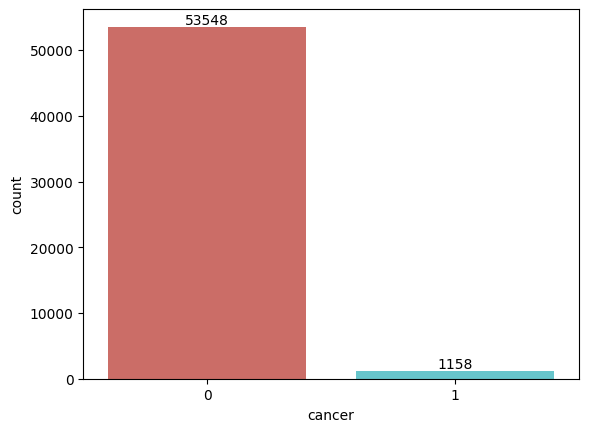

Percentage of Positive is: 97.8832303586444
Percentage of Malignant is: 2.11676964135561


In [5]:
import seaborn as sns # boxplot, histplot

ax=sns.countplot(x='cancer', data=df_train, palette='hls')
plt.bar_label(ax.containers[0])
plt.show()
count_positive = len(df_train[df_train['cancer']==0])
count_malignant = len(df_train[df_train['cancer']==1])
pct_of_positive = count_positive/(count_positive+count_malignant)
print("Percentage of Positive is:", pct_of_positive*100)
pct_of_malignant = count_malignant/(count_positive+count_malignant)
print("Percentage of Malignant is:", pct_of_malignant*100)

In [6]:
# The latest keras-preprocessing
# Source Code: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
# Modified by Jia Lin
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-6u6ppqnh
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-6u6ppqnh
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-py3-none-any.whl size=43615 sha256=26fc8095a757312403994fe9bd8ddccd80e6ac7f89e9a12be14078d8b1f0a27e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hspliyri/wheels/72/0b/c7/3f6b26f2d789c712867e02502e1f1b740091f8615f32a9f870
Successfully built Keras-Preprocessing


# Keras ImageDataGenerator to map the images in the RSNA_256 directory to the class cancer in the corresponing train.csv file

In [7]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

In [8]:
# Create image_name matching the name in the image name directory by concatenating the patient_id and image_id
df_train['image_name'] = df_train["patient_id"].astype(str) + '_' + df_train["image_id"].astype(str)
df_test['image_name'] = df_test["patient_id"].astype(str) + '_' + df_test["image_id"].astype(str)

print(df_train.head())
print(df_test.head())

   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

         image_name  
0   10006_462822612  
1  10006_1459541791  
2  10006_18645

In [9]:
# The append_ext function is defined to append extension to the image name
def append_ext(fname):
    return fname+'.png'
df_train['image_name']=df_train['image_name'].apply(append_ext)
df_test['image_name']=df_test['image_name'].apply(append_ext)

print(df_train.head())
print(df_test.head())

   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  \
0         0     NaN        0     NaN          29                    False   
1         0     NaN        0     NaN          29                    False   
2         0     NaN        0     NaN          29                    False   
3         0     NaN        0     NaN          29                    False   
4         0     0.0        0     NaN          21                     True   

             image_name  
0   10006_462822612.png  
1  10006_1459541791.png  
2 

In [10]:
!ls "/content/gdrive/My Drive/testing_images"

10008_1591370361.png  10008_68070693.png
10008_361203119.png   10008_736471439.png


# Split the RSNA_256 set into two dataset, one is training set, the other is validation set. The training set contains 75% of images, while the validation set is composed of 25% of images.

The batch_size of the training set and the validation set has set as the number that divides the total number of images in the train set and valid respectively.

In [11]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
train_generator=datagen.flow_from_dataframe(dataframe=df_train,
                                            directory="/content/gdrive/My Drive/RSNA_256/",
                                            x_col="image_name",
                                            y_col="cancer",
                                            subset="training",
                                            batch_size=373, # 41030 = 373*110
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw", # 'cancer' is numerical datatype
                                            target_size=(256,256))
valid_generator=datagen.flow_from_dataframe(dataframe=df_train,
                                            directory="/content/gdrive/My Drive/RSNA_256/",
                                            x_col="image_name",
                                            y_col="cancer",
                                            subset="validation",
                                            batch_size=263, # 13676 = 263*52
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw", # 'cancer' is numerical datatype
                                            target_size=(256,256))

/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:283: UserWarning: Found 3 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


Found 41028 validated image filenames.
Found 13676 validated image filenames.


In [12]:
#print(df_test.head())
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory="/content/gdrive/My Drive/testing_images/",
                                                x_col="image_name",
                                                y_col=None,
                                                batch_size=4,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(256,256))

Found 4 validated image filenames.


# Build the model:

In [13]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax')) # Two classes output

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                        

In [15]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fitting/Training the model

In [16]:
#model.fit(train_generator, validation_data=valid_generator, epochs=4)